### In this notebook, we will see how we can use autoencoder as a classifier with fashion MNIST dataset.
- Fashion MNIST dataset is a 28x28 grayscale images of 70,000 fashion products from 10 categories, with 7,000 images per category. The training set has 60,000 images, and the test set has 10,000 images.
- It is a replacement for the original MNIST handwritten digits dataset for producing better results. The Fashion MNIST dataset consists of 10 different classes of fashion accessories like shirts, trousers, sandals, etc 
- The image dimensions, training and test splits are similar to the original MNIST dataset. 
- The dataset is freely available on this URL and can be loaded using both tensorflow and keras as a framework without having to download it on your computer.

So, We build a convolutional autoencoder and use the encoder part of it combined with fully connected layers to recognize a new sample from the test set correctly.

In [5]:
# Loading the dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gzip

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten,Dropout, Reshape, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as k
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

# import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

The way we read the data is as follows:
- We open and read the gzip file as bytestream
- We then convert the string stored in buffer using np.frombuffer() to numpy array of type float32.
- Data is then reshaped into a 3-dimentional array.

### Loading the data

In [6]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buffer = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buffer, dtype = np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [7]:
train_data = extract_data('data/train-images-idx3-ubyte.gz' ,60000)
test_data = extract_data('data/t10k-images-idx3-ubyte.gz',10000)

The way we read the labels is the same as we read the data:
- We define a function which opens the label file as a bytestream using bytestream.read() to which you pass the label dimension as 1 and the total number of images.
- We then convert the string stored in the buffer to a numpy array of type int64.
- We do not need to reshape the array since the variable labels will return a column vector of dimension 60,000 x 1.

In [8]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buffer = bytestream.read(1 * num_images)
        labels = np.frombuffer(buffer, dtype = np.uint8).astype(np.uint64)
        return labels

In [9]:
train_labels = extract_labels('data/train-labels-idx1-ubyte.gz', 60000)
test_labels = extract_labels('data/t10k-labels-idx1-ubyte.gz',10000)

In [10]:
train_labels[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint64)

### Data Exploration

In [11]:
# To see the dimension of images in the training set
print("Training set (images) shape: {shape}", format(train_data.shape))

# To see the dimension of images in the test set
print("Test set (image) shape: {shape}", format(test_data.shape))

Training set (images) shape: {shape} (60000, 28, 28)
Test set (image) shape: {shape} (10000, 28, 28)


We don't need training an testing labels for convolutional encoder as the task at hand is to reconstruct the images. However, we do need them for classification task and for data exploration purposes.

In [12]:
# we will now create a dictionary of class names with their corresponding class labels:
label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J' 
}

Let us now look at few of the images in the dataset

Text(0.5, 1.0, '(Label: E)')

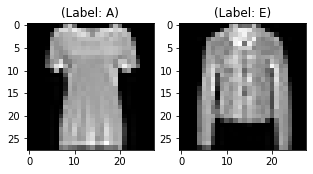

In [13]:
plt.figure(figsize=[5,5])

# display an image from the training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_label = train_labels[10]
plt.imshow(curr_img, cmap = 'gray')
plt.title("(Label: " + str(label_dict[curr_label]) + ")")

# display an image from the testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_label = test_labels[10]
plt.imshow(curr_img, cmap= 'gray')
plt.title("(Label: " + str(label_dict[curr_label])+ ")")

These images are assigned class labels as 0 or A / 4 or E. This means all the alphabets having class of E will have the class label of 4.


### Data Preprocessing

We need to do the preprocessing of the data before feeding it to the model as our images are gray scale images having pixel values ranging from 0 to 255 with dimension of 28 * 28.
So we will convert each 28 * 28 image into a matrix of size 28 * 28 * 1 which can be fed to the network.

In [14]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

Train data shape (60000, 28, 28, 1)
Test data shape (10000, 28, 28, 1)


In [15]:
# checking the datatype of the numpy arrays
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [16]:
# rescaling the pixel values to 0-1 scale by rescaling with maximum pixel value of the training and testing data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [17]:
# verify the maximum value of the training and the testing data
np.max(train_data), np.max(test_data)

(1.0, 1.0)

### Splitting the data into train and validation sets

In [18]:
# We will now split the data into 80% training and 20% validation. This will help us to reduce the chances of overfitting
# as you would be validating the model on the data it has not seen in the training.
X_train, X_val, y_train, y_val = train_test_split(train_data, train_data, test_size = 0.2, random_state = 12345)

In [19]:
X_train.shape, X_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

In [20]:
# Now the data is ready to be fed to the network. 
batch_size = 128
epochs = 200
channel = 1
x, y = 28, 28
input_image = Input(shape = (x, y, channel))
num_classes = 10

We will build encoder and a decoder using convolutional layers.
Batch Normalization layer is used

In [21]:
# Building an encoder
def encoder(input_image):
    # input dimension - 28 * 28 * 1
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (input_image)  # 28 *28 * 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)  # 14 * 14 * 32
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (pool1) # 14 * 14 * 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2)) (conv2) # 7 * 7 * 64
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (pool2) # 7 * 7 * 128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256,(3,3), activation = 'relu', padding = 'same') (conv3) # 7 * 7 * 256
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same') (conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [22]:
# Building a decoder
def decoder(conv4):
    conv5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv4) # 7 * 7 * 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3,3), activation= 'relu', padding ='same') (conv5)# 7 * 7 * 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3,3), activation= 'relu', padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2)) (conv6)  # 14 * 14 * 64
    conv7 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (up1)# 14 * 14 * 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3,3), activation ='relu', padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 * 28 * 32
    decoded = Conv2D(1,(3, 3),  activation = 'sigmoid', padding ='same') (up2) # 28 * 28 * 1
    return decoded

In [23]:
# Compiling the model using RMSProp optimizer (helps in reducing overfitting by 
# changing learning rate while the model is training) and specifying the loss as mean squared loss
autoencoder = Model(input_image, decoder(encoder(input_image)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [24]:
# Let us see the autoencoder summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

### Training the model 

In [26]:
# we will now train the autoencoder for 200 epochs using keras fit function
# We are going to save the history to plot accuracy and loss curves to help in analyzing the model performance.
csv_logger = CSVLogger('autoencoder_log.csv', append = True, separator = ';')
history = autoencoder.fit(X_train, y_train, batch_size = batch_size, epochs= 3,
                                   verbose =1, validation_data = (X_val, y_val), callbacks = [csv_logger])

Epoch 1/3
375/375 [==============================] - 469s 1s/step - loss: 0.0213 - val_loss: 0.0205
Epoch 2/3
375/375 [==============================] - 427s 1s/step - loss: 0.0110 - val_loss: 0.0141
Epoch 3/3
375/375 [==============================] - 427s 1s/step - loss: 0.0083 - val_loss: 0.0093


In [27]:
# saving the model
autoencoder_json = autoencoder.to_json()
with open('autoencoder_json','w') as json_file:
    json_file.write(autoencoder_json)

dict_keys(['loss', 'val_loss'])


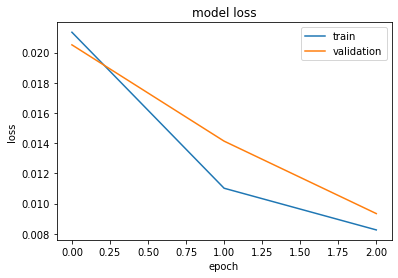

In [28]:
# Now we can plot the loss curves to visualize the model performance
# list all data in history
print(history.history.keys())


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

We can clearly see that the training and validation loss are in sync. The validation loss is decreasing which is a good sign which also mean that model is not overfitting. So, we can say the model's generalization capabity is good.

Now, we will use the encoder part of the autoencoder to classify the fashion MNIST images.

In [29]:
# We will need the encoder weights of the autoencoder for classification task. We will now save the 
# full autoencoder weights and then we will learn to extract the encoder weights.
autoencoder.save_weights('autoencoder_weights.h5')

### Classifying the fashion MNIST images

- Loading the encoder weights from the trained autoencoder's weight
- We will add a few fully connected (dense) layers to the encoder to classify the fashion MNIST images.
- We will convert labels into one-hot encoding vectors. In one-hot encoding, we convert the categorical values to
    a vector of numbers as machine learning algorithms cannot work with understand categorical data directly.
- So, in our case the one hot encoding will be a row vector and for each image it will have a dimension of 1 X 10.
- The vector consists of all zeros except for the class that it represents, and for that, it is 1.


In [30]:
X_train_one_hot = to_categorical(train_labels)
X_test_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('One-hot label:', X_train_one_hot[0])

Original label: 9
One-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [31]:
# Splitting the data again into train and test for classification purpose using the one hot labels this time
X_trainc, X_valc, y_trainc, y_valc = train_test_split(train_data, X_train_one_hot, test_size = 0.2, random_state = 12345)

In [32]:
# checking the shape
X_trainc.shape, X_valc.shape, y_trainc.shape, y_valc.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [33]:
# Now we will be using building the classification model using the encoder part (define encoder) of the autoencoder
# defining the fully connected layer for the encoder part
def fc(enco):
    flat = Flatten() (enco)
    fc1 = Dense(128, activation = 'relu') (flat)
    fc2 = Dense(num_classes, activation = 'softmax') (fc1)
    return fc2

In [34]:
encode = encoder(input_image)
full_model = Model(input_image, fc(encode))

In [35]:
for l1, l2 in zip(full_model.layers[:19], autoencoder.layers[:19]):
    l1.set_weights(l2.get_weights())

In [36]:
# Since, we are using the encoder part of the autoencoder for classification purpose, we should make sure that
# the weights of the encoder part of the autoencoder are are similar to the weights you loaded to the 
# encoder function of the classification model. If they are not similar, there is no pointin using the autoencoder classification
# strategy.

# First layer weight of autoencoder
autoencoder.get_weights()[0][1]

array([[[ 0.08241735, -0.06421845,  0.02842346,  0.1619661 ,
          0.03857473,  0.15650488,  0.05071606, -0.05502138,
         -0.05562655,  0.02708507,  0.04688932, -0.07629649,
          0.02296582, -0.01266363, -0.13520005, -0.06607167,
         -0.05505665,  0.08732482,  0.04399852, -0.02368761,
          0.01784851,  0.01296654,  0.10374463, -0.06800147,
         -0.05752411, -0.02878271, -0.09894527, -0.04959425,
          0.11079976, -0.10491682, -0.00057545, -0.11319549]],

       [[ 0.05259172, -0.05649609,  0.16621964,  0.18729258,
         -0.02263106,  0.12691337, -0.05846724,  0.10117585,
         -0.11876594, -0.0756285 , -0.11449174,  0.05852647,
          0.04335602, -0.07521233, -0.00814126,  0.12053021,
         -0.03413882,  0.02436592, -0.11702696,  0.08189123,
         -0.01605618, -0.14527121,  0.07664929,  0.00885528,
          0.10463632,  0.05614497, -0.05753338,  0.0082215 ,
         -0.12300898, -0.02319348,  0.01485936, -0.12879033]],

       [[-0.023118

In [37]:
full_model.get_weights()[0][1]

array([[[ 0.08241735, -0.06421845,  0.02842346,  0.1619661 ,
          0.03857473,  0.15650488,  0.05071606, -0.05502138,
         -0.05562655,  0.02708507,  0.04688932, -0.07629649,
          0.02296582, -0.01266363, -0.13520005, -0.06607167,
         -0.05505665,  0.08732482,  0.04399852, -0.02368761,
          0.01784851,  0.01296654,  0.10374463, -0.06800147,
         -0.05752411, -0.02878271, -0.09894527, -0.04959425,
          0.11079976, -0.10491682, -0.00057545, -0.11319549]],

       [[ 0.05259172, -0.05649609,  0.16621964,  0.18729258,
         -0.02263106,  0.12691337, -0.05846724,  0.10117585,
         -0.11876594, -0.0756285 , -0.11449174,  0.05852647,
          0.04335602, -0.07521233, -0.00814126,  0.12053021,
         -0.03413882,  0.02436592, -0.11702696,  0.08189123,
         -0.01605618, -0.14527121,  0.07664929,  0.00885528,
          0.10463632,  0.05614497, -0.05753338,  0.0082215 ,
         -0.12300898, -0.02319348,  0.01485936, -0.12879033]],

       [[-0.023118

The weights are similar, so we can move further and compile the model and start the training

In [38]:
# Since the encoder part is already trained, we do not need to train it again. So, we will make those 
# 19 layers of the model as trainable false. We will only train the fully connected layer part
for layer in full_model.layers[:19]:
    layer.trainable = False

In [39]:
# Now, we will compile the model
full_model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [40]:
# summary of the model
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)        1849

### Training the classification model

In [41]:
# Training the model for 100 epochs using the keras fit function and visualizing the accuracy and loss curves

history_classification = full_model.fit(X_train, y_trainc, batch_size = 64, epochs= 2,
                                   verbose =1, validation_data = (X_valc, y_valc))

Epoch 1/2
750/750 [==============================] - 91s 119ms/step - loss: 0.5255 - accuracy: 0.8429 - val_loss: 0.3514 - val_accuracy: 0.8784
Epoch 2/2
750/750 [==============================] - 98s 131ms/step - loss: 0.3165 - accuracy: 0.8851 - val_loss: 0.3280 - val_accuracy: 0.8832


In [42]:
# Saving the classification model's weights
full_model.save_weights('full_model_weights.h5')

### Retraining the full model

In [43]:
# Now we will retrain the full model along with the other 19 layers
for layer in full_model.layers[:19]:
    layer.trainable = True

In [44]:
# Now, we will compile the model
full_model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [45]:
history_classification = full_model.fit(X_train, y_trainc, batch_size = 64, epochs= 2,
                                   verbose =1, validation_data = (X_valc, y_valc))

Epoch 1/2
750/750 [==============================] - 353s 456ms/step - loss: 0.3273 - accuracy: 0.8823 - val_loss: 0.2696 - val_accuracy: 0.9024
Epoch 2/2
750/750 [==============================] - 297s 396ms/step - loss: 0.2352 - accuracy: 0.9135 - val_loss: 0.2536 - val_accuracy: 0.9092


In [46]:
# Saving the complete model now
full_model.save_weights('full_model_complete.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


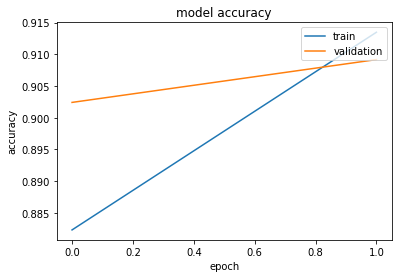

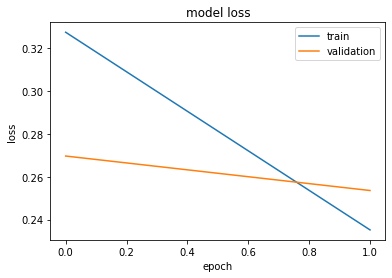

In [48]:
# plotting the accuracy and loss curves
# Now we can plot the loss curves to visualize the model performance
# list all data in history
print(history_classification.history.keys())

# summarize history for loss
plt.plot(history_classification.history['accuracy'])
plt.plot(history_classification.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history_classification.history['loss'])
plt.plot(history_classification.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Model evaluation on the test set

In [49]:
test_eval = full_model.evaluate(test_data, X_test_one_hot, verbose=1)

313/313 [==============================] - 15s 46ms/step - loss: 0.2768 - accuracy: 0.9024


In [50]:
# Let us see the test accuracy and loss
print('Test Accuracy', test_eval[0])
print('Test Loss', test_eval[1])

Test Accuracy 0.2767554819583893
Test Loss 0.902400016784668


### Prediction

In [51]:
predicted_classes = full_model.predict(test_data)
print(predicted_classes[1])

[2.14046086e-05 1.06495005e-14 9.97303009e-01 3.81219706e-07
 2.03410885e-03 1.58219915e-17 6.41008199e-04 6.56856006e-21
 1.78900788e-08 5.85208818e-18]


In [52]:
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

In [53]:
print(predicted_classes[1])

2


In [54]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Correctly identified samples are:  8944


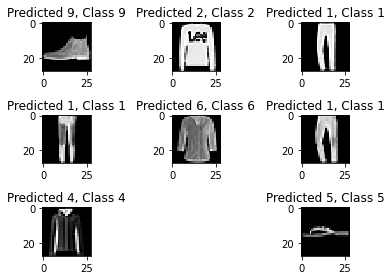

In [55]:
# finding the correct predicted labels
correct = np.where(predicted_classes == test_labels)[0]

print("Correctly identified samples are: ", len(correct))
for i,correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Incorrectly identified samples are:  1056


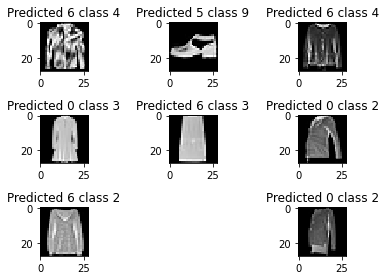

In [56]:
# finding the incorrect predictions
incorrect = np.where(predicted_classes != test_labels)[0]

print("Incorrectly identified samples are: ", len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted {} class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

### Metrics

In [57]:
# Accuracy
print("Accuracy: ", accuracy_score(test_labels, predicted_classes))

Accuracy:  0.8944


In [58]:
# Classification report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.72      0.82      0.77      1000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.94      0.76      0.84      1000
     Class 3       0.93      0.87      0.90      1000
     Class 4       0.86      0.84      0.85      1000
     Class 5       0.98      0.98      0.98      1000
     Class 6       0.69      0.79      0.74      1000
     Class 7       0.95      0.96      0.96      1000
     Class 8       0.97      0.98      0.98      1000
     Class 9       0.98      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.89      0.90     10000



In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint64)

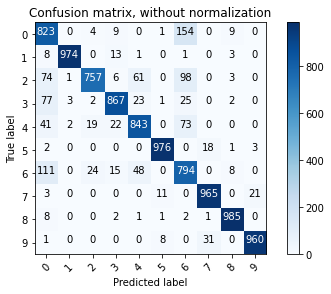

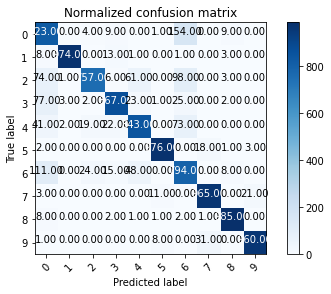

In [61]:
class_names = np.unique(test_labels)

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()